This notebook parses sgf files generated by selfplay (or victimplay).

It presents the files in a searchable and filterable way,
and allows one to easily export files for viewing in Sabaki.

### Load libraries

In [1]:
from IPython.display import display

import dataclasses
import os
import posix
import random
import re
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
sys.path.append("../engines/KataGo-custom/python")

from sgfmill import sgf

### Load games

In [36]:
DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp127-vis32"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp127-vis64"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp127-vis512-try2"

SELFPLAY_DIR = f"{DATA_DIR}/selfplay"
RAW_SGF_STRS: List[str] = []

bot_de: posix.DirEntry
for bot_de in tqdm([de for de in os.scandir(SELFPLAY_DIR) if de.is_dir()]):

    sgfs_path = os.path.join(bot_de.path, "sgfs")
    for sgf_de in [de for de in os.scandir(sgfs_path) if de.is_file()]:
        sgf_path: str = sgf_de.path
        with open(sgf_path) as f:
            for line in f.readlines():
                RAW_SGF_STRS.append(line.strip())

len(RAW_SGF_STRS)

  0%|          | 0/118 [00:00<?, ?it/s]

384819

### Parse games

In [37]:
@dataclasses.dataclass
class GameInfo:
    board_size: int
    gtype: str
    start_turn_idx: int
    init_turn_num: int
    used_initial_position: bool

    victim_color: str
    adv_color: str
    win_color: str

    adv_name: str
    adv_steps: int
    adv_win: bool
    adv_minus_victim_score: float  # With komi
    adv_minus_victim_score_wo_komi: float  # No komi

    komi: float  # Positive if white has the advantage
    adv_komi: float  # Positive if adv has the advantage

    # Number of extra stones black places at start of game,
    # equivalent to the number of white passes at start of game.
    handicap: int
    has_handicap: bool  # Whether handicap is nonzero

    is_continuation: bool  # Whether game is continuation of previous game

    # Total number of moves (including passes)
    num_moves: int

    # How many times each player passed
    num_b_pass: int
    num_w_pass: int
    num_adv_pass: int  # Number of time adversary passed in the game
    num_victim_pass: int  # Number of times victim passed in the game

    ko_rule: str
    score_rule: str
    tax_rule: str
    sui_legal: bool
    has_button: bool
    whb: str  # whiteHandicapBonus
    fpok: bool  # friendly pass ok

    sgf_str: str  # raw sgf string


def get_game_info(sgf_str: str) -> GameInfo:
    sgf_game = sgf.Sgf_game.from_string(sgf_str)

    b_name = sgf_game.get_player_name("b")
    w_name = sgf_game.get_player_name("w")

    victim_color = {b_name: "b", w_name: "w"}["victim"]
    adv_color = {"b": "w", "w": "b"}[victim_color]

    adv_raw_name = {"b": b_name, "w": w_name}[adv_color]
    adv_name = (
        adv_raw_name.split("__victim")[0]
        if adv_color == "b"
        else adv_raw_name.split("victim__")[1]
    )
    adv_steps = (
        0
        if adv_name == "random"
        else int(re.search(r"\-s([0-9]+)\-", adv_name).group(1))
    )

    win_color = sgf_game.get_winner()
    lose_color = {"b": "w", "w": "b", None: None}[win_color]

    if win_color is None:
        adv_minus_victim_score = 0
    else:
        win_score = float(sgf_game.get_root().get("RE").split("+")[1])
        adv_minus_victim_score = {
            win_color: win_score,
            lose_color: -win_score,
        }[adv_color]

    komi = sgf_game.get_komi()
    adv_komi = {"w": komi, "b": -komi}[adv_color]

    handicap = int(sgf_game.root.get("HA"))

    def comment_prop(
        prop_name: str,
        default=None,
    ) -> str:
        comments = sgf_game.root.get("C")
        if prop_name not in comments:
            return default
        return comments.split(f"{prop_name}=")[1].split(",")[0]

    rule_str = sgf_game.root.get("RU")

    num_b_pass: int = sum(
        node.get_move() == ("b", None) for node in sgf_game.get_main_sequence()
    )
    num_w_pass: int = sum(
        node.get_move() == ("w", None) for node in sgf_game.get_main_sequence()
    )

    return GameInfo(
        board_size=sgf_game.get_size(),
        gtype=comment_prop("gtype"),
        start_turn_idx=int(comment_prop("startTurnIdx")),
        init_turn_num=int(comment_prop("initTurnNum")),
        used_initial_position=comment_prop("usedInitialPosition") == "1",
        victim_color=victim_color,
        adv_color=adv_color,
        win_color=win_color,
        adv_name=adv_name,
        adv_steps=adv_steps,
        adv_win=adv_color == win_color,
        adv_minus_victim_score=adv_minus_victim_score,
        adv_minus_victim_score_wo_komi=adv_minus_victim_score - adv_komi,
        komi=komi,
        adv_komi=adv_komi,
        handicap=handicap,
        has_handicap=handicap > 0,
        is_continuation=sgf_game.get_root().has_setup_stones(),
        num_moves=len(sgf_game.get_main_sequence()) - 1,
        num_b_pass=num_b_pass,
        num_w_pass=num_w_pass,
        num_adv_pass={"b": num_b_pass, "w": num_w_pass}[adv_color],
        num_victim_pass={"b": num_b_pass, "w": num_w_pass}[victim_color],
        sgf_str=sgf_str,
        ko_rule=re.search(r"ko([A-Z]+)", rule_str).group(1),
        score_rule=re.search(r"score([A-Z]+)", rule_str).group(1),
        tax_rule=re.search(r"tax([A-Z]+)", rule_str).group(1),
        sui_legal=re.search(r"sui([0-9])", rule_str).group(1) == "1",
        has_button="button1" in rule_str,
        whb=re.search(r"whb([A-Z0-9\-]+)", rule_str).group(1)
        if "whb" in rule_str
        else "0",
        fpok="fpok" in rule_str,
    )


random.seed(42)
GAME_INFOS: List[GameInfo] = process_map(
    get_game_info,
    RAW_SGF_STRS,
    max_workers=64,
    chunksize=50,
)


  0%|          | 0/384819 [00:00<?, ?it/s]

In [38]:
%%time
df = pd.DataFrame(
    [dataclasses.asdict(gi) for gi in GAME_INFOS]
)
print("gtypes:", df.gtype.unique())
print("Number of cleanup games:", (df.gtype == "cleanuptraining").sum())

# Filter to only normal games
df = df[(df.gtype == 'normal')]
print("Fraction continuation:    ", df.is_continuation.mean())
print("Fraction used_initial_pos:", df.used_initial_position.mean())
print("max(init_turn_num)       :", df.init_turn_num.max())

df.head()

gtypes: ['normal']
Number of cleanup games: 0
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
CPU times: user 21.1 s, sys: 583 ms, total: 21.7 s
Wall time: 21.7 s


,board_size,gtype,start_turn_idx,init_turn_num,used_initial_position,victim_color,adv_color,win_color,adv_name,adv_steps,...,num_adv_pass,num_victim_pass,ko_rule,score_rule,tax_rule,sui_legal,has_button,whb,fpok,sgf_str
0,9,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,7,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[9]PB[victim]PW[victim__t0-s2234...
1,7,normal,0,0,False,w,b,w,t0-s22349312-d5511896,22349312,...,7,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[7]PB[t0-s22349312-d5511896__vic...
2,9,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,8,2,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[9]PB[victim]PW[victim__t0-s2234...
3,10,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,9,2,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[10]PB[victim]PW[victim__t0-s223...
4,12,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,8,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[12]PB[victim]PW[victim__t0-s223...


In [39]:
df19 = df[df.board_size == 19]
df19.head()

,board_size,gtype,start_turn_idx,init_turn_num,used_initial_position,victim_color,adv_color,win_color,adv_name,adv_steps,...,num_adv_pass,num_victim_pass,ko_rule,score_rule,tax_rule,sui_legal,has_button,whb,fpok,sgf_str
66,19,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,2,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s223...
79,19,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,3,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s223...
81,19,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,7,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s223...
82,19,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,1,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s223...
83,19,normal,0,0,False,b,w,w,t0-s22349312-d5511896,22349312,...,4,1,POSITIONAL,AREA,NONE,True,False,0,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s223...


### Analyze data

In [40]:
def hist_3d(
    df: pd.DataFrame,
    t_key: str,
    ts: np.ndarray,
    v_key: str,
    ax: plt.Axes,
    cmap: plt.cm.ScalarMappable = plt.cm.inferno,
    bins: int = 50,
):
    """Adapted from https://stackoverflow.com/a/65126279/1337463"""
    ts = np.sort(ts)

    #calculate now the histogram and plot it for each column
    for i, t in enumerate(ts):
        #extract the current column from your df by its number
        col = df[df[t_key] == t][v_key]

        #determine the histogram values, here you have to adapt it to your needs
        histvals, edges = np.histogram(col, bins=bins, density=True)

        #calculate the center and width of each bar
        #obviously not necessary to do this for each column if you always have the same bins 
        #but if you choose for np.histogram other parameters, the bins may not be the same for each histogram
        xcenter = np.convolve(edges, np.ones(2), "valid")/2
        xwidth = np.diff(edges)

        #plot the histogram as a bar for each bin
        #now with continuous color mapping and edgecolor, so we can better see all bars
        ax.bar(left=xcenter, height=histvals, width=xwidth, zs=t, zdir="y", color=cmap(1-i/len(ts)), alpha=0.666, edgecolor="grey")

    ax.set_xlabel(v_key)
    ax.set_ylabel(t_key);
    ax.set_zlabel("density")

    ax.set_ylim(ts[-1],ts[0])
    ax.set_yticks(ts[::10])

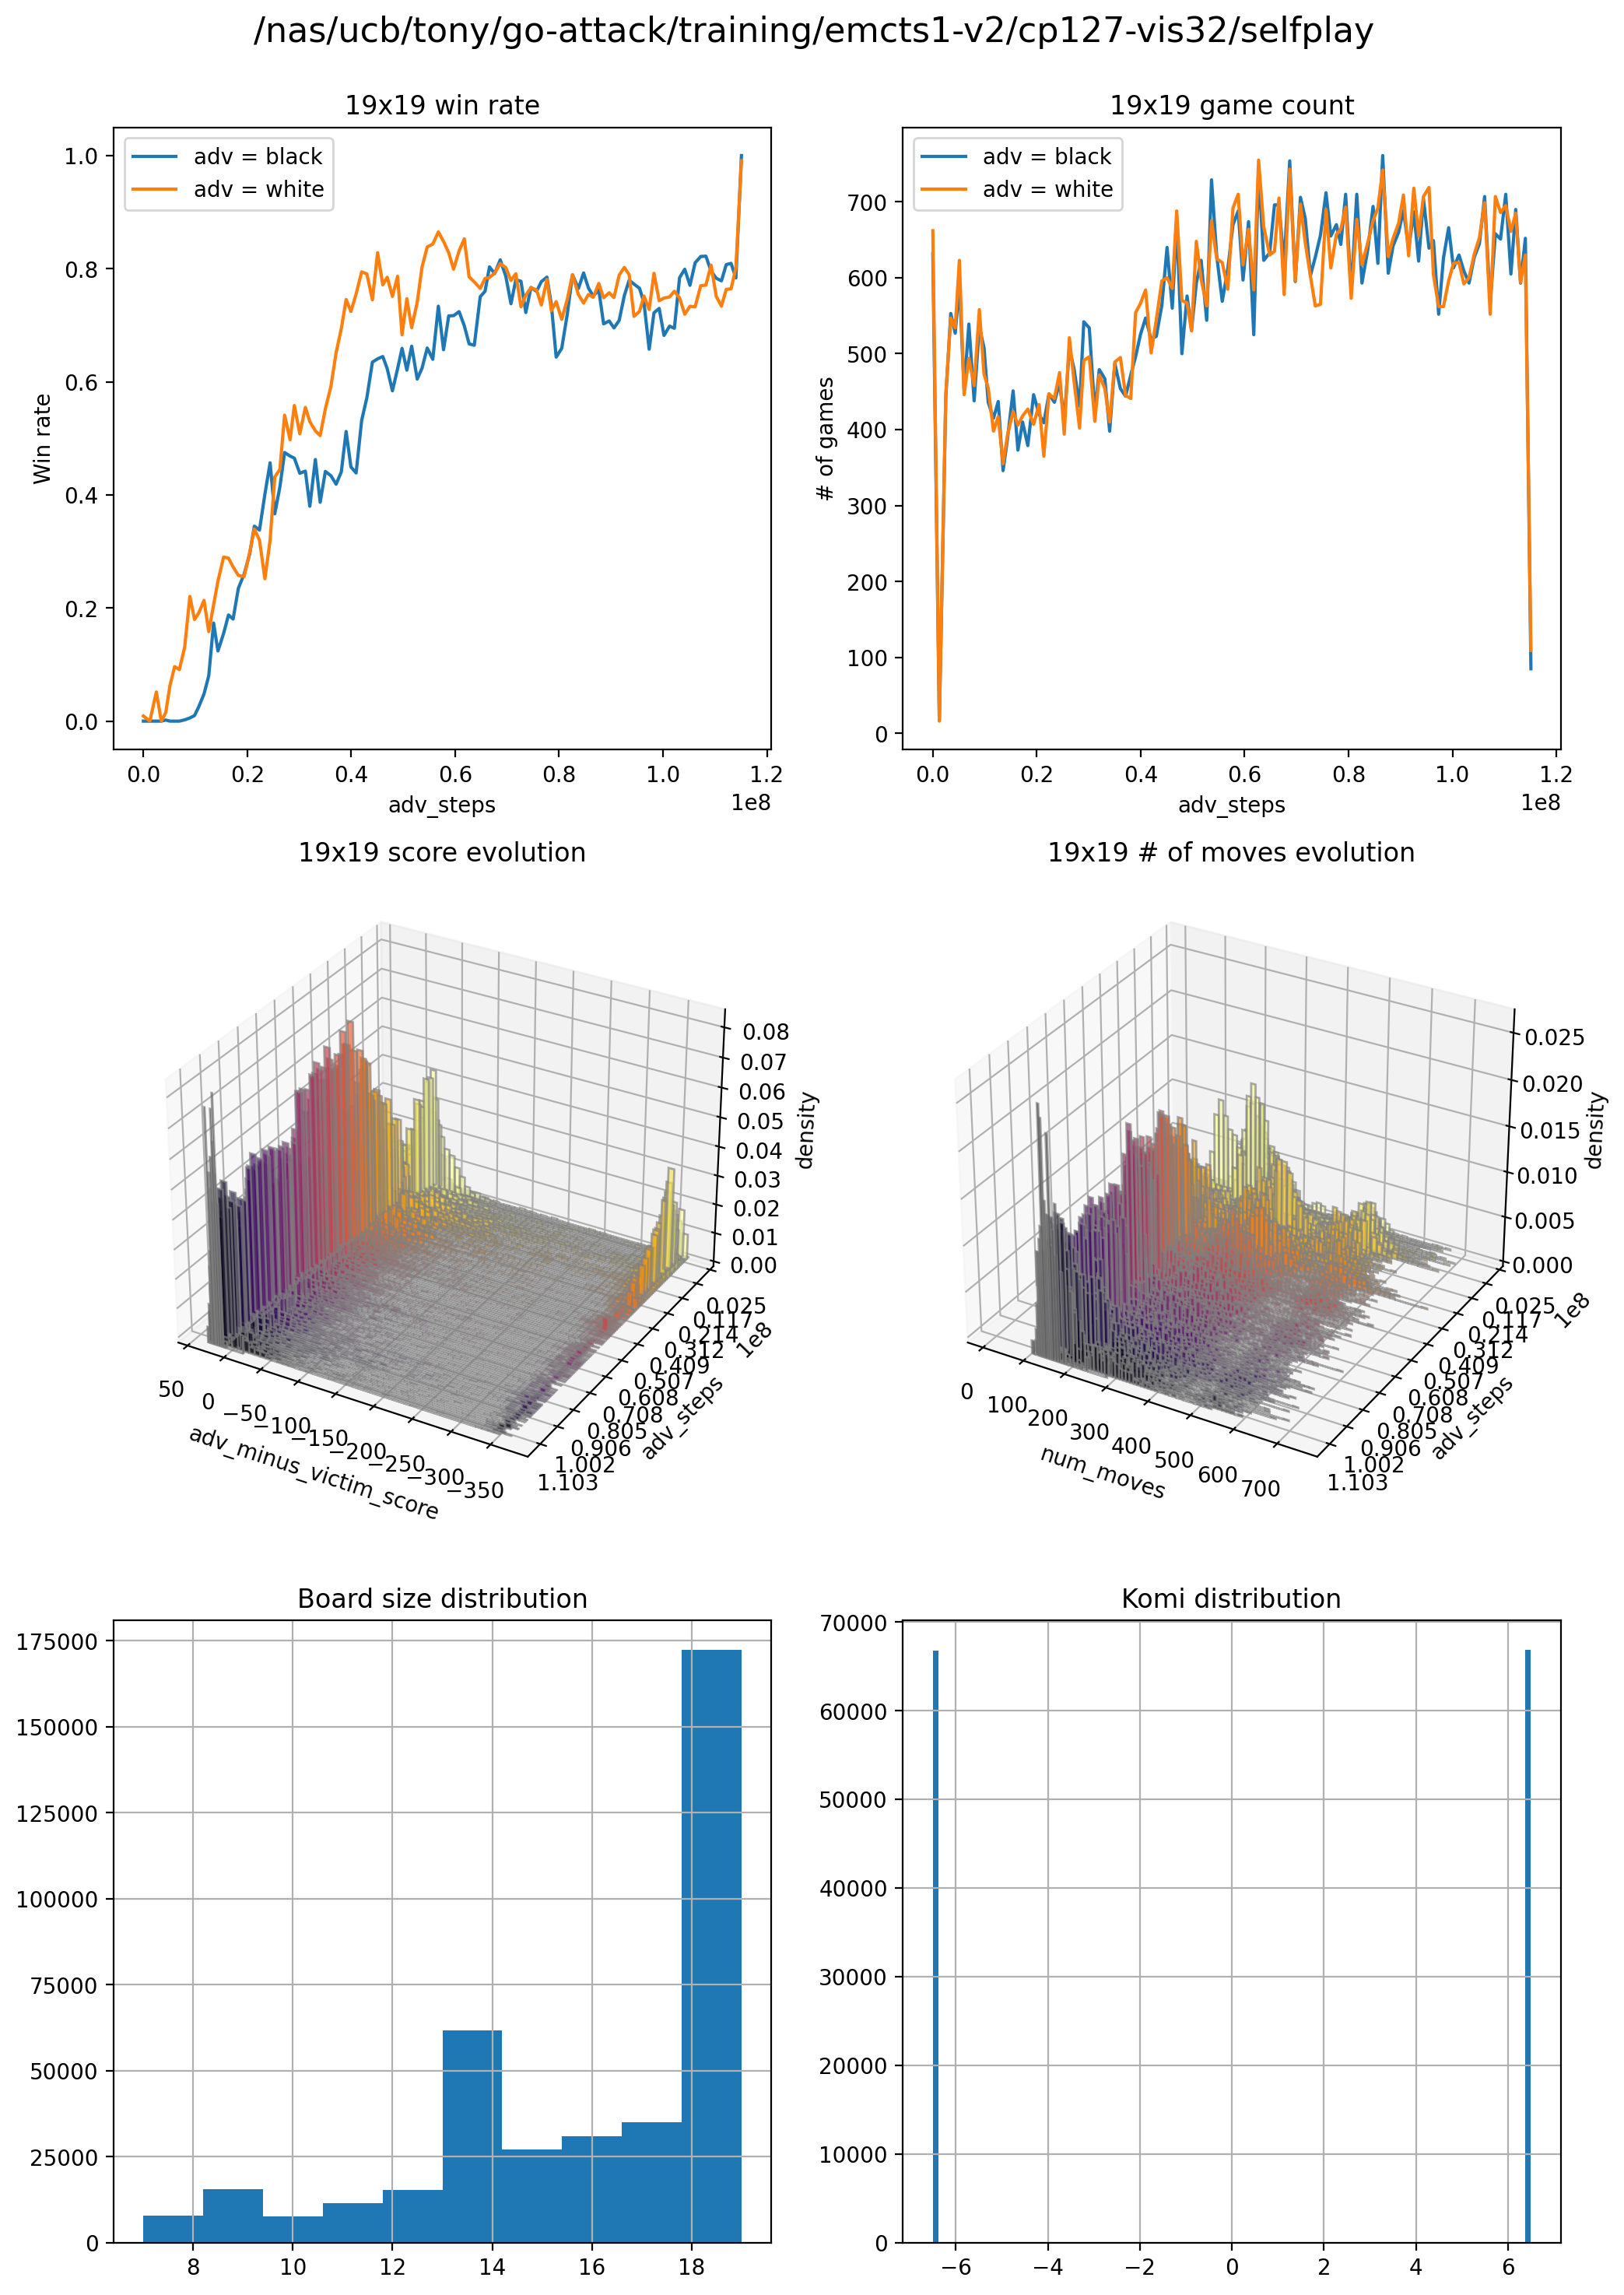

In [41]:
plt.figure(figsize=(12, 18), dpi=200)
plt.suptitle(SELFPLAY_DIR, fontsize=16, y=0.92);

plt.subplot(3, 2, 1)
df19[df19.adv_color == "b"].groupby("adv_steps").mean().adv_win.plot(label="adv = black")
df19[df19.adv_color == "w"].groupby("adv_steps").mean().adv_win.plot(label="adv = white")
plt.ylabel("Win rate"); plt.title("19x19 win rate")
plt.legend()

plt.subplot(3, 2, 2)
df19[df19.adv_color == "b"].groupby("adv_steps").count().adv_win.plot(label="adv = black")
df19[df19.adv_color == "w"].groupby("adv_steps").count().adv_win.plot(label="adv = white")
plt.ylabel("# of games"); plt.title("19x19 game count")
plt.legend()

ax = plt.subplot(3, 2, 3, projection="3d")
hist_3d(df19, ts=np.sort(df19.adv_steps.unique())[2:], t_key="adv_steps", v_key="adv_minus_victim_score", ax=ax)
ax.invert_xaxis()
plt.title("19x19 score evolution")

ax = plt.subplot(3, 2, 4, projection="3d")
hist_3d(df19, ts=np.sort(df19.adv_steps.unique())[2:], t_key="adv_steps", v_key="num_moves", ax=ax)
plt.title("19x19 # of moves evolution")

plt.subplot(3, 2, 5)
df.board_size.hist()
plt.title("Board size distribution");

plt.subplot(3, 2, 6)
df19.adv_komi.hist(bins=100);
plt.title("Komi distribution");

### Games

In [42]:
def sgf_str_to_url(sgf_str: str) -> str:
    return f"https://humancompatibleai.github.io/sgf-viewer/#sgf={sgf_str}"

@dataclasses.dataclass(frozen=True)
class Url:
    """Wrapper around a URL string to provide nice display in IPython environments."""

    url: str
    text: str

    def _repr_html_(self):
        """HTML link to this URL."""
        return f'<a href="{self.url}">{self.text}</a>'

    def __str__(self):
        """Return the underlying string."""
        return self.url

In [43]:
ADV_STEP_VIZ = list(sorted(df19.adv_steps.unique()))[-5]
print(ADV_STEP_VIZ)

df_win = df19[(df19.adv_steps == ADV_STEP_VIZ) & df19.adv_win]
print(df_win.adv_color.unique())

df_loss = df19[(df19.adv_steps == ADV_STEP_VIZ) & ~df19.adv_win]
print(df_loss.adv_color.unique())

111258368
['w' 'b']
['w' 'b']


Text(0.5, 1.0, 'Adv. losses')

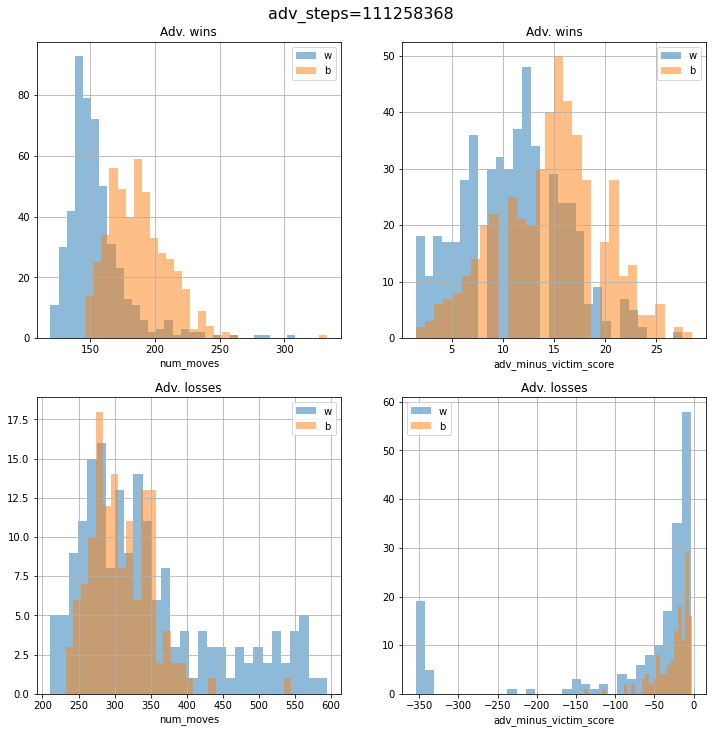

In [44]:
plt.figure(figsize=(12, 12))
plt.suptitle(f"adv_steps={ADV_STEP_VIZ}", fontsize=16, y=0.92);

plt.subplot(2, 2, 1)
df_win[df_win.adv_color == "w"].num_moves.hist(bins=30, label="w", alpha=0.5)
df_win[df_win.adv_color == "b"].num_moves.hist(bins=30, label="b", alpha=0.5)
plt.legend();
plt.xlabel("num_moves"); plt.title("Adv. wins")

plt.subplot(2, 2, 2)
df_win[df_win.adv_color == "w"].adv_minus_victim_score.hist(bins=30, label="w", alpha=0.5)
df_win[df_win.adv_color == "b"].adv_minus_victim_score.hist(bins=30, label="b", alpha=0.5)
plt.legend();
plt.xlabel("adv_minus_victim_score"); plt.title("Adv. wins")

plt.subplot(2, 2, 3)
df_loss[df_loss.adv_color == "w"].num_moves.hist(bins=30, label="w", alpha=0.5)
df_loss[df_loss.adv_color == "b"].num_moves.hist(bins=30, label="b", alpha=0.5)
plt.legend();
plt.xlabel("num_moves"); plt.title("Adv. losses")

plt.subplot(2, 2, 4)
df_loss[df_loss.adv_color == "w"].adv_minus_victim_score.hist(bins=30, label="w", alpha=0.5)
df_loss[df_loss.adv_color == "b"].adv_minus_victim_score.hist(bins=30, label="b", alpha=0.5)
plt.legend();
plt.xlabel("adv_minus_victim_score"); plt.title("Adv. losses")

In [45]:
for df_cur, lab in [(df_win, "win"), (df_loss, "loss")]:
    for color in ["b", "w"]:
        for i in range(2):
            display(
                Url(
                    url=sgf_str_to_url(df_cur[df_cur.adv_color == color].sgf_str.iloc[i]),
                    text=f"{color}_{lab}{i}={ADV_STEP_VIZ}",
                )
            )

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s111258368-d28022411__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+7.5]C[startTurnIdx=0,initTurnNum=0,gameHash=91F9984DF389147ED502C0D9DA8A8ECA,gtype=normal];B[bb]C[0.21 0.79 0.00 -12.6 v=600 weight=0.66];W[dp]C[0.74 0.26 0.00 5.9 v=32 weight=0.76];B[rr]C[0.20 0.80 0.00 -13.0 v=600 weight=0.72];W[pc]C[0.93 0.07 0.00 13.4 v=32 weight=0.88];B[br]C[0.19 0.81 0.00 -13.2 v=600 weight=0.89];W[dd]C[0.97 0.03 0.00 16.7 v=32 weight=0.93];B[rb]C[0.19 0.81 0.00 -13.2 v=600 weight=0.77];W[qd]C[0.98 0.02 0.00 19.5 v=32 weight=1.01];B[mp]C[0.19 0.81 0.00 -13.4 v=600 weight=1.09];W[cn]C[0.98 0.02 0.00 19.5 v=32 weight=1.30];B[no]C[0.19 0.81 0.00 -13.2 v=600 weight=0.82];W[dr]C[0.99 0.01 0.00 21.4 v=32 weight=1.08];B[rd]C[0.20 0.80 0.00 -12.8 v=600 weight=0.79];W[qe]C[0.99 0.01 0.00 22.5 v=32 weight=1.07];B[ql]C[0.19 0.81 0.00 -12.8 v=600 weight=0.75];W[cc]C[0.99 0.01 0.00 23.3 v=32 weight=1.08];B[bd]C[0.20 0.80 0.00 -12.6 v=600 weight=0.76];W[ce]C[0.99 0.01 0.00 24.8 v=32 weight=1.09];B[rk]C[0.20 0.80 0.00 -12.5 v=600 weight=0.78];W[qq]C[1.00 0.00 0.00 26.9 v=32 weight=1.11];B[db]C[0.20 0.80 0.00 -12.4 v=600 weight=0.88];W[qo]C[1.00 0.00 0.00 29.1 v=32 weight=1.04];B[bp]C[0.19 0.81 0.00 -12.5 v=600 weight=0.74];W[nq]C[1.00 0.00 0.00 29.4 v=32 weight=1.05];B[rf]C[0.20 0.80 0.00 -12.2 v=600 weight=0.87];W[re]C[1.00 0.00 0.00 30.9 v=32 weight=1.00];B[pr]C[0.20 0.80 0.00 -12.4 v=600 weight=0.86];W[pq]C[1.00 0.00 0.00 33.3 v=32 weight=0.86];B[aq]C[0.19 0.81 0.00 -12.3 v=600 weight=0.81];W[mq]C[1.00 0.00 0.00 39.0 v=32 weight=1.00];B[nr]C[0.20 0.80 0.00 -11.6 v=600 weight=0.82];W[or]C[1.00 0.00 0.00 43.8 v=32 weight=0.95];B[mo]C[0.19 0.81 0.00 -12.2 v=600 weight=0.63];W[kp]C[1.00 0.00 0.00 50.2 v=32 weight=1.02];B[rp]C[0.19 0.81 0.00 -11.8 v=600 weight=0.78];W[pn]C[1.00 0.00 0.00 55.1 v=32 weight=1.08];B[bf]C[0.19 0.81 0.00 -11.9 v=600 weight=0.70];W[om]C[1.00 0.00 0.00 57.7 v=32 weight=0.99];B[al]C[0.19 0.81 0.00 -12.2 v=600 weight=0.60];W[qj]C[1.00 0.00 0.00 63.5 v=32 weight=0.97];B[rh]C[0.19 0.81 0.00 -12.3 v=600 weight=0.71];W[rj]C[1.00 0.00 0.00 65.6 v=32 weight=1.08];B[mb]C[0.20 0.80 0.00 -12.3 v=600 weight=0.69];W[oj]C[1.00 0.00 0.00 69.4 v=32 weight=1.00];B[ma]C[0.19 0.81 0.00 -12.4 v=600 weight=0.64];W[jn]C[1.00 0.00 0.00 80.9 v=32 weight=1.03];B[os]C[0.21 0.79 0.00 -11.2 v=600 weight=0.81];W[oq]C[1.00 0.00 0.00 83.4 v=32 weight=0.79];B[pf]C[0.20 0.80 0.00 -11.5 v=600 weight=0.63];W[qf]C[1.00 0.00 0.00 81.9 v=32 weight=1.06];B[og]C[0.19 0.81 0.00 -11.9 v=600 weight=0.68];W[qg]C[1.00 0.00 0.00 89.0 v=32 weight=0.88];B[ms]C[0.19 0.81 0.00 -11.8 v=600 weight=0.62];W[cg]C[1.00 0.00 0.00 101.6 v=32 weight=1.09];B[ac]C[0.19 0.81 0.00 -11.4 v=600 weight=0.68];W[cb]C[1.00 0.00 0.00 109.6 v=32 weight=1.16];B[lr]C[0.19 0.81 0.00 -11.4 v=600 weight=0.66];W[iq]C[1.00 0.00 0.00 112.5 v=32 weight=0.96];B[ga]C[0.19 0.81 0.00 -11.7 v=600 weight=0.76];W[ic]C[1.00 0.00 0.00 123.6 v=32 weight=1.11];B[fs]C[0.19 0.81 0.00 -11.6 v=600 weight=0.76];W[md]C[1.00 0.00 0.00 131.5 v=32 weight=1.10];B[sl]C[0.19 0.81 0.00 -11.6 v=600 weight=0.66];W[kd]C[1.00 0.00 0.00 138.7 v=32 weight=1.09];B[of]C[0.19 0.81 0.00 -11.7 v=600 weight=0.64];W[li]C[1.00 0.00 0.00 149.2 v=32 weight=1.14];B[bm]C[0.18 0.82 0.00 -11.5 v=600 weight=0.65];W[dl]C[1.00 0.00 0.00 152.2 v=32 weight=1.08];B[fe]C[0.18 0.82 0.00 -11.4 v=600 weight=0.62];W[fc]C[1.00 0.00 0.00 148.8 v=32 weight=1.04];B[oa]C[0.19 0.81 0.00 -11.0 v=600 weight=0.70];W[pb]C[1.00 0.00 0.00 160.8 v=32 weight=1.08];B[sc]C[0.19 0.81 0.00 -11.4 v=600 weight=0.71];W[hi]C[1.00 0.00 0.00 167.5 v=32 weight=1.04];B[ea]C[0.19 0.81 0.00 -11.4 v=600 weight=0.70];W[hb]C[1.00 0.00 0.00 174.5 v=32 weight=0.93];B[fb]C[0.18 0.82 0.00 -12.0 v=600 weight=0.70];W[ec]C[1.00 0.00 0.00 179.8 v=32 weight=1.00];B[ff]C[0.18 0.82 0.00 -12.2 v=600 weight=0.70];W[dh]C[1.00 0.00 0.00 188.0 v=32 weight=1.01];B[gf]C[0.17 0.83 0.00 -12.3 v=600 weigh

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s111258368-d28022411__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+18.5]C[startTurnIdx=0,initTurnNum=0,gameHash=9DE36A247B6217F8309215A4DDD078DF,gtype=normal];B[rr]C[0.21 0.79 0.00 -12.6 v=600 weight=0.69];W[dc]C[0.75 0.25 0.00 5.9 v=32 weight=0.79];B[br]C[0.19 0.81 0.00 -13.2 v=600 weight=0.78];W[pd]C[0.91 0.09 0.00 12.9 v=32 weight=0.91];B[bb]C[0.19 0.81 0.00 -13.2 v=600 weight=0.78];W[cd]C[0.97 0.03 0.00 17.4 v=32 weight=0.96];B[rb]C[0.19 0.81 0.00 -13.4 v=600 weight=0.80];W[qc]C[0.99 0.01 0.00 20.4 v=32 weight=1.07];B[nh]C[0.19 0.81 0.00 -13.5 v=600 weight=0.85];W[pp]C[0.99 0.01 0.00 20.8 v=32 weight=1.16];B[jh]C[0.19 0.81 0.00 -13.4 v=600 weight=0.90];W[kd]C[0.99 0.01 0.00 21.3 v=32 weight=1.04];B[rp]C[0.19 0.81 0.00 -13.3 v=600 weight=0.85];W[hd]C[0.99 0.01 0.00 22.7 v=32 weight=1.11];B[lh]C[0.20 0.80 0.00 -12.9 v=600 weight=0.87];W[mp]C[0.99 0.01 0.00 23.1 v=32 weight=1.11];B[pr]C[0.21 0.79 0.00 -12.5 v=600 weight=0.84];W[qg]C[0.99 0.01 0.00 24.2 v=32 weight=1.13];B[pb]C[0.22 0.78 0.00 -12.3 v=600 weight=0.70];W[mc]C[0.99 0.01 0.00 25.2 v=32 weight=1.08];B[dr]C[0.22 0.78 0.00 -12.3 v=600 weight=0.73];W[qb]C[1.00 0.00 0.00 26.1 v=32 weight=1.12];B[rd]C[0.22 0.78 0.00 -12.4 v=600 weight=0.97];W[qe]C[1.00 0.00 0.00 28.3 v=32 weight=1.21];B[rf]C[0.21 0.79 0.00 -12.3 v=600 weight=0.69];W[qi]C[1.00 0.00 0.00 30.6 v=32 weight=1.07];B[rh]C[0.21 0.79 0.00 -12.4 v=600 weight=1.27];W[qh]C[1.00 0.00 0.00 31.9 v=32 weight=0.91];B[bd]C[0.21 0.79 0.00 -12.3 v=600 weight=1.01];W[bc]C[1.00 0.00 0.00 32.1 v=32 weight=1.02];B[ac]C[0.21 0.79 0.00 -12.2 v=600 weight=1.21];W[cc]C[1.00 0.00 0.00 32.7 v=32 weight=0.92];B[nr]C[0.19 0.81 0.00 -11.6 v=600 weight=0.71];W[cg]C[1.00 0.00 0.00 36.9 v=32 weight=1.04];B[db]C[0.19 0.81 0.00 -11.7 v=600 weight=0.74];W[ec]C[1.00 0.00 0.00 39.4 v=32 weight=0.88];B[nb]C[0.18 0.82 0.00 -12.3 v=600 weight=0.63];W[nc]C[1.00 0.00 0.00 41.1 v=32 weight=1.11];B[ih]C[0.18 0.82 0.00 -12.6 v=600 weight=0.61];W[ql]C[1.00 0.00 0.00 46.1 v=32 weight=1.11];B[bp]C[0.18 0.82 0.00 -12.5 v=600 weight=1.05];W[dj]C[1.00 0.00 0.00 49.0 v=32 weight=1.10];B[rn]C[0.17 0.83 0.00 -12.7 v=600 weight=0.67];W[jp]C[1.00 0.00 0.00 50.4 v=32 weight=1.05];B[is]C[0.18 0.82 0.00 -12.8 v=600 weight=0.73];W[kg]C[1.00 0.00 0.00 56.6 v=32 weight=0.97];B[qa]C[0.17 0.83 0.00 -13.1 v=600 weight=0.70];W[rc]C[1.00 0.00 0.00 57.6 v=32 weight=1.00];B[ae]C[0.16 0.84 0.00 -13.9 v=600 weight=0.65];W[kh]C[1.00 0.00 0.00 65.1 v=32 weight=1.04];B[lb]C[0.16 0.84 0.00 -13.8 v=600 weight=0.61];W[ki]C[1.00 0.00 0.00 70.8 v=32 weight=0.92];B[mh]C[0.16 0.84 0.00 -13.8 v=600 weight=0.63];W[mb]C[1.00 0.00 0.00 82.8 v=32 weight=1.05];B[bf]C[0.15 0.85 0.00 -13.5 v=600 weight=0.73];W[ce]C[1.00 0.00 0.00 82.3 v=32 weight=0.99];B[hs]C[0.15 0.85 0.00 -14.0 v=600 weight=0.64];W[ij]C[1.00 0.00 0.00 94.9 v=32 weight=0.94];B[bh]C[0.16 0.84 0.00 -13.1 v=600 weight=0.66];W[ch]C[1.00 0.00 0.00 96.8 v=32 weight=0.96];B[ig]C[0.15 0.85 0.00 -13.4 v=600 weight=0.69];W[gj]C[1.00 0.00 0.00 108.0 v=32 weight=0.93];B[ic]C[0.15 0.85 0.00 -13.1 v=600 weight=0.65];W[hc]C[1.00 0.00 0.00 105.6 v=32 weight=0.97];B[jd]C[0.16 0.84 0.00 -12.8 v=600 weight=0.78];W[kc]C[1.00 0.00 0.00 110.7 v=32 weight=0.85];B[gb]C[0.17 0.83 0.00 -12.6 v=600 weight=0.63];W[hb]C[1.00 0.00 0.00 110.2 v=32 weight=0.87];B[sm]C[0.17 0.83 0.00 -12.7 v=600 weight=0.64];W[mk]C[1.00 0.00 0.00 121.8 v=32 weight=1.19];B[pf]C[0.17 0.83 0.00 -12.6 v=600 weight=0.66];W[qf]C[1.00 0.00 0.00 121.5 v=32 weight=1.02];B[ee]C[0.17 0.83 0.00 -13.2 v=600 weight=0.71];W[bg]C[1.00 0.00 0.00 134.4 v=32 weight=0.92];B[si]C[0.17 0.83 0.00 -13.0 v=600 weight=0.73];W[pn]C[1.00 0.00 0.00 142.0 v=32 weight=0.92];B[rk]C[0.17 0.83 0.00 -13.1 v=600 weight=0.90];W[qk]C[1.00 0.00 0.00 146.1 v=32 weight=0.97];B[df]C[0.18 0.82 0.00 -12.5 v=600 weight=0.84];W[cf]C[1.00 0.00 0.00 147.5 v=32 weight=0.86];B[gd]C[0.17 0.83 0.00 -12.8 v=600 weight=0

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s111258368-d28022411]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+13.5]C[startTurnIdx=0,initTurnNum=0,gameHash=1B7FEE6CFA46D3F26DFA2FE4F9F66616,gtype=normal];B[dd]C[0.46 0.54 0.00 -0.2 v=32 weight=0.73];W[rb]C[0.82 0.18 0.00 9.6 v=600 weight=0.84];B[qp]C[0.18 0.82 0.00 -7.1 v=32 weight=0.74];W[ki]C[0.82 0.18 0.00 9.8 v=600 weight=0.76];B[dq]C[0.09 0.91 0.00 -10.5 v=32 weight=0.80];W[jf]C[0.81 0.19 0.00 9.5 v=600 weight=0.76];B[pe]C[0.08 0.92 0.00 -11.6 v=32 weight=0.86];W[rr]C[0.81 0.19 0.00 9.2 v=600 weight=0.73];B[pq]C[0.03 0.97 0.00 -15.4 v=32 weight=0.88];W[ro]C[0.81 0.19 0.00 9.2 v=600 weight=0.69];B[rp]C[0.02 0.98 0.00 -17.0 v=32 weight=1.01];W[bb]C[0.81 0.19 0.00 9.5 v=600 weight=0.69];B[ck]C[0.01 0.99 0.00 -20.1 v=32 weight=1.17];W[il]C[0.81 0.19 0.00 9.6 v=600 weight=0.62];B[oc]C[0.01 0.99 0.00 -21.2 v=32 weight=1.06];W[br]C[0.81 0.19 0.00 9.3 v=600 weight=0.68];B[cp]C[0.01 0.99 0.00 -25.0 v=32 weight=1.11];W[pb]C[0.80 0.20 0.00 9.4 v=600 weight=0.66];B[qc]C[0.00 1.00 0.00 -26.4 v=32 weight=1.17];W[ak]C[0.80 0.20 0.00 9.6 v=600 weight=0.72];B[cf]C[0.00 1.00 0.00 -34.1 v=32 weight=1.14];W[bl]C[0.80 0.20 0.00 9.7 v=600 weight=0.60];B[db]C[0.00 1.00 0.00 -36.3 v=32 weight=1.06];W[bj]C[0.80 0.20 0.00 9.8 v=600 weight=0.61];B[qj]C[0.00 1.00 0.00 -39.6 v=32 weight=1.12];W[nb]C[0.80 0.20 0.00 9.8 v=600 weight=0.58];B[ob]C[0.00 1.00 0.00 -41.1 v=32 weight=1.09];W[kh]C[0.81 0.19 0.00 10.0 v=600 weight=0.70];B[kc]C[0.00 1.00 0.00 -45.7 v=32 weight=1.12];W[oa]C[0.81 0.19 0.00 9.8 v=600 weight=0.64];B[nc]C[0.00 1.00 0.00 -49.3 v=32 weight=0.90];W[dr]C[0.81 0.19 0.00 10.2 v=600 weight=0.59];B[cr]C[0.00 1.00 0.00 -49.9 v=32 weight=1.00];W[cs]C[0.80 0.20 0.00 9.9 v=600 weight=0.98];B[cq]C[0.00 1.00 0.00 -51.8 v=32 weight=0.92];W[nd]C[0.82 0.18 0.00 10.7 v=600 weight=0.61];B[mc]C[0.00 1.00 0.00 -56.3 v=32 weight=0.92];W[qs]C[0.82 0.18 0.00 11.1 v=600 weight=0.62];B[nq]C[0.00 1.00 0.00 -65.8 v=32 weight=0.96];W[pd]C[0.82 0.18 0.00 11.2 v=600 weight=0.64];B[pc]C[0.00 1.00 0.00 -66.5 v=32 weight=0.85];W[oe]C[0.83 0.17 0.00 11.8 v=600 weight=0.63];B[pf]C[0.00 1.00 0.00 -71.1 v=32 weight=1.18];W[se]C[0.82 0.18 0.00 11.5 v=600 weight=0.62];B[ph]C[0.00 1.00 0.00 -80.3 v=32 weight=0.98];W[rd]C[0.82 0.18 0.00 11.6 v=600 weight=0.65];B[rf]C[0.00 1.00 0.00 -80.9 v=32 weight=1.04];W[jn]C[0.83 0.17 0.00 11.9 v=600 weight=0.63];B[gq]C[0.00 1.00 0.00 -81.7 v=32 weight=1.05];W[qa]C[0.83 0.17 0.00 11.8 v=600 weight=0.62];B[ko]C[0.00 1.00 0.00 -91.3 v=32 weight=1.03];W[li]C[0.82 0.18 0.00 11.5 v=600 weight=0.75];B[jo]C[0.00 1.00 0.00 -97.9 v=32 weight=1.05];W[jm]C[0.82 0.18 0.00 11.4 v=600 weight=0.62];B[lm]C[0.00 1.00 0.00 -102.6 v=32 weight=1.11];W[ma]C[0.82 0.18 0.00 11.2 v=600 weight=0.67];B[lk]C[0.00 1.00 0.00 -113.8 v=32 weight=1.00];W[lb]C[0.82 0.18 0.00 11.2 v=600 weight=0.73];B[lc]C[0.00 1.00 0.00 -115.2 v=32 weight=0.95];W[re]C[0.82 0.18 0.00 11.3 v=600 weight=0.68];B[rc]C[0.00 1.00 0.00 -121.7 v=32 weight=0.96];W[bp]C[0.82 0.18 0.00 11.0 v=600 weight=0.63];B[co]C[0.00 1.00 0.00 -126.1 v=32 weight=0.97];W[im]C[0.83 0.17 0.00 11.7 v=600 weight=0.61];B[ie]C[0.00 1.00 0.00 -135.7 v=32 weight=0.95];W[bn]C[0.83 0.17 0.00 11.3 v=600 weight=0.61];B[cm]C[0.00 1.00 0.00 -135.0 v=32 weight=1.01];W[sm]C[0.84 0.16 0.00 11.7 v=600 weight=0.70];B[jk]C[0.00 1.00 0.00 -145.1 v=32 weight=1.09];W[rl]C[0.83 0.17 0.00 11.4 v=600 weight=0.61];B[hj]C[0.00 1.00 0.00 -149.4 v=32 weight=0.98];W[fh]C[0.83 0.17 0.00 11.4 v=600 weight=0.71];B[hg]C[0.00 1.00 0.00 -152.5 v=32 weight=1.01];W[or]C[0.83 0.17 0.00 11.3 v=600 weight=0.66];B[ih]C[0.00 1.00 0.00 -155.3 v=32 weight=1.08];W[mi]C[0.83 0.17 0.00 11.3 v=600 weight=0.68];B[nj]C[0.00 1.00 0.00 -161.2 v=32 weight=1.02];W[in]C[0.83 0.17 0.00 11.0 v=600 weight=0.73];B[ek]C[0.00 1.00 0.00 -174.7 v=32 weight=1.01];W[rn]C[0.82 0.18 0.00 10.5 v=600 weight=0.67];B[em]C[0.00 1.00 0.00 -180.8 v=32 weight=0.96];W[pk]C[0

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s111258368-d28022411]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+12.5]C[startTurnIdx=0,initTurnNum=0,gameHash=13004B2205EF4B70618A5FDB4E536ECA,gtype=normal];B[kf]C[0.45 0.55 0.00 -0.4 v=32 weight=0.71];W[br]C[0.81 0.19 0.00 9.3 v=600 weight=1.15];B[cd]C[0.24 0.76 0.00 -5.5 v=32 weight=0.75];W[bb]C[0.81 0.19 0.00 9.5 v=600 weight=0.82];B[dc]C[0.08 0.92 0.00 -11.6 v=32 weight=0.88];W[ld]C[0.81 0.19 0.00 9.6 v=600 weight=0.80];B[pd]C[0.06 0.94 0.00 -13.3 v=32 weight=0.93];W[mm]C[0.81 0.19 0.00 9.6 v=600 weight=0.81];B[qp]C[0.04 0.96 0.00 -15.2 v=32 weight=1.00];W[no]C[0.81 0.19 0.00 9.3 v=600 weight=0.71];B[jc]C[0.03 0.97 0.00 -15.8 v=32 weight=1.21];W[rb]C[0.80 0.20 0.00 9.0 v=600 weight=0.72];B[qc]C[0.02 0.98 0.00 -18.2 v=32 weight=1.20];W[hp]C[0.80 0.20 0.00 9.0 v=600 weight=0.78];B[je]C[0.01 0.99 0.00 -19.1 v=32 weight=1.20];W[hi]C[0.80 0.20 0.00 8.7 v=600 weight=0.73];B[fj]C[0.01 0.99 0.00 -20.8 v=32 weight=1.18];W[rr]C[0.79 0.21 0.00 8.2 v=600 weight=0.74];B[pq]C[0.01 0.99 0.00 -23.4 v=32 weight=1.13];W[ac]C[0.79 0.21 0.00 8.5 v=600 weight=0.77];B[cf]C[0.00 1.00 0.00 -30.4 v=32 weight=1.24];W[pa]C[0.78 0.22 0.00 8.6 v=600 weight=0.73];B[oc]C[0.00 1.00 0.00 -37.7 v=32 weight=1.14];W[qa]C[0.78 0.22 0.00 8.4 v=600 weight=0.86];B[qf]C[0.00 1.00 0.00 -48.2 v=32 weight=1.10];W[bd]C[0.78 0.22 0.00 8.6 v=600 weight=0.87];B[cc]C[0.00 1.00 0.00 -48.7 v=32 weight=1.21];W[db]C[0.79 0.21 0.00 9.0 v=600 weight=0.97];B[cb]C[0.00 1.00 0.00 -54.0 v=32 weight=1.13];W[md]C[0.80 0.20 0.00 9.5 v=600 weight=0.68];B[mf]C[0.00 1.00 0.00 -59.7 v=32 weight=1.10];W[os]C[0.80 0.20 0.00 9.6 v=600 weight=0.69];B[nq]C[0.00 1.00 0.00 -67.8 v=32 weight=1.17];W[mc]C[0.81 0.19 0.00 9.8 v=600 weight=0.66];B[nb]C[0.00 1.00 0.00 -73.2 v=32 weight=1.12];W[sh]C[0.81 0.19 0.00 10.0 v=600 weight=0.65];B[do]C[0.00 1.00 0.00 -82.0 v=32 weight=1.02];W[ai]C[0.81 0.19 0.00 9.9 v=600 weight=0.74];B[ci]C[0.00 1.00 0.00 -89.1 v=32 weight=1.08];W[pr]C[0.81 0.19 0.00 10.0 v=600 weight=0.71];B[qr]C[0.00 1.00 0.00 -89.0 v=32 weight=1.14];W[ls]C[0.81 0.19 0.00 10.2 v=600 weight=0.63];B[lq]C[0.00 1.00 0.00 -97.1 v=32 weight=1.18];W[ea]C[0.81 0.19 0.00 10.0 v=600 weight=0.67];B[ec]C[0.00 1.00 0.00 -104.4 v=32 weight=1.15];W[qi]C[0.81 0.19 0.00 10.2 v=600 weight=0.63];B[hk]C[0.00 1.00 0.00 -104.8 v=32 weight=1.10];W[qs]C[0.81 0.19 0.00 10.1 v=600 weight=0.75];B[qq]C[0.00 1.00 0.00 -105.9 v=32 weight=0.99];W[fb]C[0.81 0.19 0.00 10.2 v=600 weight=0.63];B[eq]C[0.00 1.00 0.00 -107.9 v=32 weight=1.11];W[lh]C[0.81 0.19 0.00 10.6 v=600 weight=0.63];B[jq]C[0.00 1.00 0.00 -107.9 v=32 weight=1.25];W[se]C[0.82 0.18 0.00 10.6 v=600 weight=0.74];B[gf]C[0.00 1.00 0.00 -112.2 v=32 weight=1.19];W[mo]C[0.82 0.18 0.00 10.6 v=600 weight=0.87];B[io]C[0.00 1.00 0.00 -117.0 v=32 weight=1.24];W[bj]C[0.81 0.19 0.00 10.2 v=600 weight=0.65];B[cm]C[0.00 1.00 0.00 -118.1 v=32 weight=1.23];W[pi]C[0.81 0.19 0.00 10.2 v=600 weight=0.71];B[cq]C[0.00 1.00 0.00 -122.5 v=32 weight=1.13];W[sj]C[0.81 0.19 0.00 9.9 v=600 weight=0.72];B[gh]C[0.00 1.00 0.00 -133.4 v=32 weight=1.12];W[rp]C[0.80 0.20 0.00 9.7 v=600 weight=0.74];B[rq]C[0.00 1.00 0.00 -135.8 v=32 weight=0.86];W[rd]C[0.81 0.19 0.00 10.1 v=600 weight=0.87];B[ng]C[0.00 1.00 0.00 -136.0 v=32 weight=0.93];W[dr]C[0.81 0.19 0.00 10.1 v=600 weight=0.68];B[er]C[0.01 0.99 0.00 -135.8 v=32 weight=1.10];W[lo]C[0.81 0.19 0.00 10.5 v=600 weight=0.67];B[im]C[0.00 1.00 0.00 -145.8 v=32 weight=1.05];W[ca]C[0.81 0.19 0.00 9.9 v=600 weight=0.71];B[be]C[0.00 1.00 0.00 -148.1 v=32 weight=0.90];W[ik]C[0.80 0.20 0.00 9.6 v=600 weight=0.71];B[il]C[0.00 1.00 0.00 -148.1 v=32 weight=1.01];W[ao]C[0.79 0.21 0.00 9.0 v=600 weight=0.67];B[bn]C[0.00 1.00 0.00 -154.5 v=32 weight=0.97];W[pf]C[0.79 0.21 0.00 9.2 v=600 weight=0.72];B[pg]C[0.00 1.00 0.00 -157.6 v=32 weight=0.95];W[di]C[0.79 0.21 0.00 9.2 v=600 weight=0.70];B[ch]C[0.00 1.00 0.00 -159.6 v=32 weight=0.96];W[cs]C[0.79 0

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s111258368-d28022411__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+13.5]C[startTurnIdx=0,initTurnNum=0,gameHash=A12705679EF22F10C5535CF9EFF336FF,gtype=normal];B[br]C[0.21 0.79 0.00 -12.5 v=600 weight=0.64];W[pd]C[0.74 0.26 0.00 5.9 v=32 weight=0.65];B[rb]C[0.20 0.80 0.00 -13.0 v=600 weight=0.64];W[qc]C[0.89 0.11 0.00 11.3 v=32 weight=0.71];B[dr]C[0.20 0.80 0.00 -13.1 v=600 weight=0.66];W[dc]C[0.95 0.05 0.00 14.2 v=32 weight=0.72];B[rr]C[0.21 0.79 0.00 -13.2 v=600 weight=0.66];W[op]C[0.97 0.03 0.00 18.1 v=32 weight=0.91];B[bb]C[0.21 0.79 0.00 -13.1 v=600 weight=0.77];W[cd]C[0.99 0.01 0.00 22.3 v=32 weight=0.96];B[pb]C[0.20 0.80 0.00 -13.1 v=600 weight=0.81];W[mc]C[0.99 0.01 0.00 24.2 v=32 weight=0.90];B[nb]C[0.20 0.80 0.00 -13.1 v=600 weight=0.83];W[oc]C[0.99 0.01 0.00 24.7 v=32 weight=0.92];B[qa]C[0.20 0.80 0.00 -13.1 v=600 weight=1.02];W[ob]C[1.00 0.00 0.00 30.9 v=32 weight=0.87];B[db]C[0.18 0.82 0.00 -12.7 v=600 weight=0.57];W[cb]C[1.00 0.00 0.00 30.8 v=32 weight=0.85];B[lb]C[0.18 0.82 0.00 -12.8 v=600 weight=0.73];W[gb]C[1.00 0.00 0.00 33.0 v=32 weight=0.84];B[bd]C[0.18 0.82 0.00 -12.9 v=600 weight=0.63];W[cf]C[1.00 0.00 0.00 34.7 v=32 weight=0.89];B[sn]C[0.17 0.83 0.00 -13.2 v=600 weight=0.61];W[mb]C[1.00 0.00 0.00 40.3 v=32 weight=0.90];B[pr]C[0.18 0.82 0.00 -12.9 v=600 weight=0.60];W[qi]C[1.00 0.00 0.00 42.6 v=32 weight=0.90];B[ma]C[0.18 0.82 0.00 -13.0 v=600 weight=0.64];W[lc]C[1.00 0.00 0.00 46.0 v=32 weight=0.94];B[bp]C[0.18 0.82 0.00 -12.9 v=600 weight=0.59];W[se]C[1.00 0.00 0.00 49.9 v=32 weight=0.98];B[ca]C[0.19 0.81 0.00 -12.8 v=600 weight=0.66];W[cc]C[1.00 0.00 0.00 43.8 v=32 weight=0.75];B[bn]C[0.18 0.82 0.00 -13.1 v=600 weight=0.56];W[he]C[1.00 0.00 0.00 49.4 v=32 weight=0.92];B[nr]C[0.19 0.81 0.00 -13.0 v=600 weight=0.59];W[mk]C[1.00 0.00 0.00 51.0 v=32 weight=0.97];B[gs]C[0.19 0.81 0.00 -12.9 v=600 weight=0.62];W[jh]C[1.00 0.00 0.00 59.6 v=32 weight=0.90];B[fr]C[0.20 0.80 0.00 -12.6 v=600 weight=0.59];W[pl]C[1.00 0.00 0.00 67.1 v=32 weight=0.98];B[rd]C[0.20 0.80 0.00 -12.6 v=600 weight=0.63];W[rc]C[1.00 0.00 0.00 68.1 v=32 weight=0.74];B[fa]C[0.21 0.79 0.00 -12.6 v=600 weight=0.57];W[ec]C[1.00 0.00 0.00 77.5 v=32 weight=0.90];B[sa]C[0.20 0.80 0.00 -13.0 v=600 weight=0.64];W[jk]C[1.00 0.00 0.00 90.1 v=32 weight=0.89];B[rf]C[0.20 0.80 0.00 -12.7 v=600 weight=0.71];W[rh]C[1.00 0.00 0.00 93.7 v=32 weight=0.85];B[bl]C[0.22 0.78 0.00 -12.1 v=600 weight=0.56];W[hl]C[1.00 0.00 0.00 99.2 v=32 weight=0.82];B[jb]C[0.22 0.78 0.00 -12.1 v=600 weight=0.68];W[kc]C[1.00 0.00 0.00 101.8 v=32 weight=0.81];B[sl]C[0.22 0.78 0.00 -12.4 v=600 weight=0.77];W[di]C[1.00 0.00 0.00 109.5 v=32 weight=0.87];B[sj]C[0.21 0.79 0.00 -12.5 v=600 weight=0.60];W[rk]C[1.00 0.00 0.00 115.4 v=32 weight=0.78];B[ib]C[0.21 0.79 0.00 -12.7 v=600 weight=0.60];W[el]C[1.00 0.00 0.00 127.9 v=32 weight=0.83];B[sg]C[0.21 0.79 0.00 -12.4 v=600 weight=0.57];W[qo]C[1.00 0.00 0.00 136.3 v=32 weight=0.74];B[bj]C[0.21 0.79 0.00 -12.6 v=600 weight=0.61];W[rp]C[1.00 0.00 0.00 138.9 v=32 weight=0.80];B[ka]C[0.21 0.79 0.00 -12.6 v=600 weight=0.64];W[mp]C[1.00 0.00 0.00 153.0 v=32 weight=0.81];B[oa]C[0.22 0.78 0.00 -12.4 v=600 weight=0.66];W[qd]C[1.00 0.00 0.00 150.1 v=32 weight=0.70];B[ae]C[0.22 0.78 0.00 -12.1 v=600 weight=0.63];W[bh]C[1.00 0.00 0.00 160.3 v=32 weight=0.75];B[sc]C[0.23 0.77 0.00 -11.7 v=600 weight=0.72];W[re]C[1.00 0.00 0.00 161.3 v=32 weight=0.75];B[jf]C[0.22 0.78 0.00 -11.9 v=600 weight=0.61];W[id]C[1.00 0.00 0.00 164.8 v=32 weight=0.84];B[pf]C[0.22 0.78 0.00 -11.8 v=600 weight=0.76];W[qe]C[1.00 0.00 0.00 165.6 v=32 weight=0.90];B[pg]C[0.21 0.79 0.00 -12.1 v=600 weight=0.62];W[dk]C[1.00 0.00 0.00 169.2 v=32 weight=0.82];B[ha]C[0.21 0.79 0.00 -11.9 v=600 weight=0.64];W[kb]C[1.00 0.00 0.00 174.7 v=32 weight=0.78];B[mn]C[0.21 0.79 0.00 -12.1 v=600 weight=0.67];W[ko]C[1.00 0.00 0.00 169.6 v=32 weight=0.90];B[kf]C[0.20 0.80 0.00 -12.1 v=600 wei

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s111258368-d28022411__victim]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+1.5]C[startTurnIdx=0,initTurnNum=0,gameHash=9C4F8D6676F4F45C8A85DAA9DF322A30,gtype=normal];B[rr]C[0.21 0.79 0.00 -12.6 v=600 weight=0.59];W[cp]C[0.73 0.27 0.00 5.7 v=32 weight=0.65];B[de]C[0.19 0.81 0.00 -13.2 v=600 weight=0.60];W[pc]C[0.77 0.23 0.00 6.6 v=32 weight=0.55];B[fn]C[0.20 0.80 0.00 -12.9 v=600 weight=0.65];W[cc]C[0.87 0.13 0.00 10.0 v=32 weight=0.66];B[br]C[0.20 0.80 0.00 -12.9 v=600 weight=0.63];W[dq]C[0.95 0.05 0.00 14.7 v=32 weight=0.68];B[rb]C[0.20 0.80 0.00 -12.9 v=600 weight=0.66];W[qd]C[0.97 0.03 0.00 18.0 v=32 weight=0.81];B[bb]C[0.20 0.80 0.00 -13.0 v=600 weight=0.66];W[ed]C[0.99 0.01 0.00 22.9 v=32 weight=0.90];B[oi]C[0.19 0.81 0.00 -13.1 v=600 weight=0.64];W[cm]C[0.99 0.01 0.00 24.4 v=32 weight=0.87];B[nj]C[0.20 0.80 0.00 -13.1 v=600 weight=0.70];W[op]C[0.99 0.01 0.00 26.4 v=32 weight=0.87];B[df]C[0.20 0.80 0.00 -12.6 v=600 weight=0.64];W[gd]C[1.00 0.00 0.00 27.7 v=32 weight=0.78];B[rp]C[0.20 0.80 0.00 -12.2 v=600 weight=0.73];W[bd]C[1.00 0.00 0.00 28.1 v=32 weight=0.90];B[rd]C[0.20 0.80 0.00 -12.1 v=600 weight=0.67];W[re]C[1.00 0.00 0.00 29.6 v=32 weight=0.80];B[dr]C[0.21 0.79 0.00 -12.0 v=600 weight=0.71];W[cr]C[1.00 0.00 0.00 28.7 v=32 weight=0.78];B[fr]C[0.22 0.78 0.00 -12.0 v=600 weight=0.73];W[er]C[1.00 0.00 0.00 29.9 v=32 weight=0.78];B[bp]C[0.22 0.78 0.00 -12.0 v=600 weight=0.68];W[rc]C[1.00 0.00 0.00 35.2 v=32 weight=0.82];B[hr]C[0.22 0.78 0.00 -12.0 v=600 weight=0.68];W[co]C[1.00 0.00 0.00 38.3 v=32 weight=0.78];B[dp]C[0.22 0.78 0.00 -12.0 v=600 weight=0.72];W[fq]C[1.00 0.00 0.00 44.4 v=32 weight=0.82];B[bn]C[0.19 0.81 0.00 -12.5 v=600 weight=0.73];W[ck]C[1.00 0.00 0.00 45.7 v=32 weight=0.85];B[bl]C[0.20 0.80 0.00 -12.3 v=600 weight=0.80];W[bm]C[1.00 0.00 0.00 47.1 v=32 weight=0.78];B[bj]C[0.20 0.80 0.00 -12.4 v=600 weight=0.68];W[kq]C[1.00 0.00 0.00 49.8 v=32 weight=0.77];B[rn]C[0.20 0.80 0.00 -12.3 v=600 weight=0.68];W[bk]C[1.00 0.00 0.00 51.3 v=32 weight=0.88];B[fp]C[0.20 0.80 0.00 -12.4 v=600 weight=0.71];W[gq]C[1.00 0.00 0.00 56.4 v=32 weight=0.74];B[dn]C[0.20 0.80 0.00 -13.0 v=600 weight=0.83];W[cn]C[1.00 0.00 0.00 58.7 v=32 weight=0.76];B[hp]C[0.18 0.82 0.00 -13.8 v=600 weight=0.67];W[gp]C[1.00 0.00 0.00 60.6 v=32 weight=0.77];B[ms]C[0.18 0.82 0.00 -14.2 v=600 weight=0.68];W[ho]C[1.00 0.00 0.00 66.7 v=32 weight=0.82];B[se]C[0.18 0.82 0.00 -13.4 v=600 weight=0.66];W[mq]C[1.00 0.00 0.00 70.9 v=32 weight=0.76];B[bh]C[0.17 0.83 0.00 -13.9 v=600 weight=0.63];W[bf]C[1.00 0.00 0.00 72.7 v=32 weight=0.81];B[lr]C[0.17 0.83 0.00 -14.1 v=600 weight=0.63];W[lq]C[1.00 0.00 0.00 74.7 v=32 weight=0.78];B[db]C[0.17 0.83 0.00 -14.4 v=600 weight=0.62];W[dc]C[1.00 0.00 0.00 77.7 v=32 weight=0.75];B[ef]C[0.16 0.84 0.00 -14.6 v=600 weight=0.59];W[dh]C[1.00 0.00 0.00 84.2 v=32 weight=0.78];B[pr]C[0.17 0.83 0.00 -14.3 v=600 weight=0.58];W[fh]C[1.00 0.00 0.00 86.3 v=32 weight=0.80];B[pb]C[0.17 0.83 0.00 -14.4 v=600 weight=0.62];W[hh]C[1.00 0.00 0.00 92.5 v=32 weight=0.80];B[nk]C[0.16 0.84 0.00 -15.1 v=600 weight=0.59];W[hl]C[1.00 0.00 0.00 98.7 v=32 weight=0.85];B[rl]C[0.17 0.83 0.00 -14.3 v=600 weight=0.61];W[nc]C[1.00 0.00 0.00 108.8 v=32 weight=0.82];B[ee]C[0.17 0.83 0.00 -14.3 v=600 weight=0.59];W[pa]C[1.00 0.00 0.00 118.4 v=32 weight=0.82];B[is]C[0.18 0.82 0.00 -13.8 v=600 weight=0.63];W[ic]C[1.00 0.00 0.00 116.2 v=32 weight=0.89];B[nr]C[0.18 0.82 0.00 -13.7 v=600 weight=0.65];W[jr]C[1.00 0.00 0.00 120.7 v=32 weight=0.84];B[oj]C[0.18 0.82 0.00 -14.0 v=600 weight=0.60];W[jl]C[1.00 0.00 0.00 132.5 v=32 weight=0.80];B[ks]C[0.18 0.82 0.00 -13.5 v=600 weight=0.67];W[js]C[1.00 0.00 0.00 141.6 v=32 weight=0.78];B[sc]C[0.18 0.82 0.00 -13.6 v=600 weight=0.60];W[qc]C[1.00 0.00 0.00 138.9 v=32 weight=0.69];B[oh]C[0.16 0.84 0.00 -14.3 v=600 weight=0.59];W[rf]C[1.00 0.00 0.00 146.5 v=32 weight=0.82];B[oa]C[0.16 0.84 0.00 -13.7 v=600 weight=0.56]

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s111258368-d28022411]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+8.5]C[startTurnIdx=0,initTurnNum=0,gameHash=EF1244DF98326EEB27A099A6EBFABD9B,gtype=normal];B[dq]C[0.45 0.55 0.00 -0.5 v=32 weight=0.61];W[rr]C[0.82 0.18 0.00 9.7 v=600 weight=0.74];B[pd]C[0.18 0.82 0.00 -6.8 v=32 weight=0.65];W[rl]C[0.82 0.18 0.00 9.8 v=600 weight=0.64];B[dc]C[0.08 0.92 0.00 -11.5 v=32 weight=0.68];W[ig]C[0.82 0.18 0.00 9.9 v=600 weight=0.70];B[op]C[0.05 0.95 0.00 -13.2 v=32 weight=0.77];W[bb]C[0.82 0.18 0.00 9.5 v=600 weight=0.62];B[cd]C[0.02 0.98 0.00 -16.9 v=32 weight=0.85];W[rb]C[0.82 0.18 0.00 9.6 v=600 weight=0.63];B[qo]C[0.02 0.98 0.00 -18.9 v=32 weight=0.91];W[mj]C[0.82 0.18 0.00 9.8 v=600 weight=0.62];B[mp]C[0.01 0.99 0.00 -21.2 v=32 weight=0.84];W[il]C[0.81 0.19 0.00 9.2 v=600 weight=0.57];B[qc]C[0.01 0.99 0.00 -21.1 v=32 weight=0.87];W[br]C[0.80 0.20 0.00 8.8 v=600 weight=0.58];B[cp]C[0.00 1.00 0.00 -25.0 v=32 weight=0.90];W[sh]C[0.80 0.20 0.00 8.9 v=600 weight=0.57];B[qf]C[0.00 1.00 0.00 -31.8 v=32 weight=0.88];W[nh]C[0.80 0.20 0.00 8.9 v=600 weight=0.58];B[mc]C[0.00 1.00 0.00 -33.5 v=32 weight=0.90];W[rp]C[0.79 0.21 0.00 8.5 v=600 weight=0.55];B[fc]C[0.00 1.00 0.00 -34.3 v=32 weight=0.91];W[eb]C[0.78 0.22 0.00 8.3 v=600 weight=0.55];B[cj]C[0.00 1.00 0.00 -35.1 v=32 weight=0.93];W[rg]C[0.79 0.21 0.00 8.6 v=600 weight=0.53];B[qq]C[0.00 1.00 0.00 -37.3 v=32 weight=0.86];W[pb]C[0.80 0.20 0.00 8.9 v=600 weight=0.57];B[qb]C[0.00 1.00 0.00 -39.7 v=32 weight=0.91];W[rm]C[0.80 0.20 0.00 9.2 v=600 weight=0.53];B[ro]C[0.00 1.00 0.00 -44.4 v=32 weight=0.96];W[os]C[0.80 0.20 0.00 9.2 v=600 weight=0.60];B[ph]C[0.00 1.00 0.00 -51.1 v=32 weight=0.84];W[mk]C[0.81 0.19 0.00 9.6 v=600 weight=0.56];B[jq]C[0.00 1.00 0.00 -54.5 v=32 weight=0.81];W[pr]C[0.81 0.19 0.00 9.4 v=600 weight=0.57];B[qr]C[0.00 1.00 0.00 -56.9 v=32 weight=0.79];W[ls]C[0.81 0.19 0.00 9.7 v=600 weight=0.58];B[lq]C[0.00 1.00 0.00 -65.8 v=32 weight=0.82];W[ni]C[0.81 0.19 0.00 9.5 v=600 weight=0.59];B[ri]C[0.00 1.00 0.00 -71.7 v=32 weight=0.87];W[ak]C[0.82 0.18 0.00 9.8 v=600 weight=0.53];B[qj]C[0.00 1.00 0.00 -80.1 v=32 weight=0.80];W[fm]C[0.82 0.18 0.00 9.9 v=600 weight=0.54];B[pl]C[0.00 1.00 0.00 -80.6 v=32 weight=0.77];W[bl]C[0.82 0.18 0.00 9.8 v=600 weight=0.56];B[cg]C[0.00 1.00 0.00 -81.3 v=32 weight=0.97];W[oa]C[0.82 0.18 0.00 9.9 v=600 weight=0.59];B[le]C[0.00 1.00 0.00 -92.2 v=32 weight=0.84];W[nb]C[0.82 0.18 0.00 10.0 v=600 weight=0.53];B[kc]C[0.00 1.00 0.00 -92.8 v=32 weight=0.79];W[mr]C[0.82 0.18 0.00 9.9 v=600 weight=0.62];B[kg]C[0.00 1.00 0.00 -96.7 v=32 weight=0.80];W[hg]C[0.82 0.18 0.00 10.0 v=600 weight=0.55];B[ki]C[0.00 1.00 0.00 -99.9 v=32 weight=0.78];W[on]C[0.82 0.18 0.00 9.5 v=600 weight=0.55];B[nm]C[0.00 1.00 0.00 -99.5 v=32 weight=0.84];W[rd]C[0.82 0.18 0.00 9.4 v=600 weight=0.56];B[kk]C[0.00 1.00 0.00 -101.5 v=32 weight=0.84];W[bg]C[0.82 0.18 0.00 9.6 v=600 weight=0.54];B[ll]C[0.00 1.00 0.00 -103.8 v=32 weight=0.88];W[am]C[0.82 0.18 0.00 9.8 v=600 weight=0.67];B[qd]C[0.00 1.00 0.00 -114.9 v=32 weight=0.79];W[fs]C[0.81 0.19 0.00 9.5 v=600 weight=0.54];B[gq]C[0.00 1.00 0.00 -123.1 v=32 weight=0.82];W[pm]C[0.81 0.19 0.00 9.4 v=600 weight=0.57];B[ol]C[0.00 1.00 0.00 -119.5 v=32 weight=0.78];W[pn]C[0.81 0.19 0.00 9.6 v=600 weight=0.60];B[qp]C[0.00 1.00 0.00 -136.8 v=32 weight=0.70];W[ck]C[0.81 0.19 0.00 9.4 v=600 weight=0.65];B[ij]C[0.00 1.00 0.00 -141.9 v=32 weight=0.84];W[nj]C[0.81 0.19 0.00 9.2 v=600 weight=0.62];B[gj]C[0.00 1.00 0.00 -154.9 v=32 weight=0.79];W[pp]C[0.80 0.20 0.00 8.5 v=600 weight=0.66];B[pq]C[0.00 1.00 0.00 -156.3 v=32 weight=0.71];W[ma]C[0.82 0.18 0.00 9.3 v=600 weight=0.56];B[oc]C[0.00 1.00 0.00 -165.5 v=32 weight=0.84];W[mi]C[0.82 0.18 0.00 9.6 v=600 weight=0.59];B[gf]C[0.00 1.00 0.00 -182.5 v=32 weight=0.79];W[sm]C[0.81 0.19 0.00 9.1 v=600 weight=0.55];B[el]C[0.00 1.00 0.00 -194.0 v=32 weight=0.85];W[sl]C[0.81 0.19 0.00 8.7 v=600 we

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[victim__t0-s111258368-d28022411]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+33.5]C[startTurnIdx=0,initTurnNum=0,gameHash=AE6E9B779C2869B43DE13A091A0F5DF5,gtype=normal];B[cd]C[0.44 0.56 0.00 -0.6 v=32 weight=0.66];W[rr]C[0.82 0.18 0.00 9.6 v=600 weight=0.78];B[pc]C[0.18 0.82 0.00 -7.0 v=32 weight=0.69];W[nb]C[0.82 0.18 0.00 9.9 v=600 weight=0.69];B[pe]C[0.08 0.92 0.00 -11.5 v=32 weight=0.78];W[bb]C[0.82 0.18 0.00 9.9 v=600 weight=0.65];B[dc]C[0.03 0.97 0.00 -15.6 v=32 weight=0.78];W[rb]C[0.82 0.18 0.00 10.0 v=600 weight=0.69];B[dp]C[0.02 0.98 0.00 -17.9 v=32 weight=0.92];W[br]C[0.82 0.18 0.00 10.0 v=600 weight=0.66];B[qq]C[0.01 0.99 0.00 -21.5 v=32 weight=0.93];W[rp]C[0.82 0.18 0.00 10.4 v=600 weight=0.69];B[cq]C[0.01 0.99 0.00 -23.3 v=32 weight=0.99];W[ee]C[0.82 0.18 0.00 10.4 v=600 weight=0.65];B[fc]C[0.01 0.99 0.00 -25.0 v=32 weight=0.95];W[bp]C[0.82 0.18 0.00 10.3 v=600 weight=0.61];B[dm]C[0.01 0.99 0.00 -27.2 v=32 weight=0.91];W[ns]C[0.81 0.19 0.00 10.3 v=600 weight=0.60];B[oq]C[0.00 1.00 0.00 -34.2 v=32 weight=0.98];W[ps]C[0.81 0.19 0.00 10.4 v=600 weight=0.68];B[lq]C[0.00 1.00 0.00 -40.9 v=32 weight=0.96];W[or]C[0.80 0.20 0.00 10.2 v=600 weight=0.61];B[nq]C[0.00 1.00 0.00 -45.4 v=32 weight=0.91];W[ha]C[0.80 0.20 0.00 10.3 v=600 weight=0.59];B[rq]C[0.00 1.00 0.00 -54.8 v=32 weight=0.98];W[dr]C[0.80 0.20 0.00 10.2 v=600 weight=0.57];B[fq]C[0.00 1.00 0.00 -57.8 v=32 weight=0.90];W[ac]C[0.80 0.20 0.00 10.3 v=600 weight=0.60];B[cf]C[0.00 1.00 0.00 -65.6 v=32 weight=0.84];W[ea]C[0.79 0.21 0.00 10.2 v=600 weight=0.57];B[ql]C[0.00 1.00 0.00 -73.8 v=32 weight=0.90];W[mr]C[0.79 0.21 0.00 10.1 v=600 weight=0.61];B[mq]C[0.00 1.00 0.00 -74.9 v=32 weight=0.88];W[db]C[0.79 0.21 0.00 10.4 v=600 weight=0.62];B[cb]C[0.00 1.00 0.00 -74.9 v=32 weight=0.88];W[rd]C[0.79 0.21 0.00 10.3 v=600 weight=0.65];B[qf]C[0.00 1.00 0.00 -79.1 v=32 weight=0.91];W[kr]C[0.79 0.21 0.00 10.6 v=600 weight=0.74];B[lr]C[0.00 1.00 0.00 -80.8 v=32 weight=0.81];W[ls]C[0.80 0.20 0.00 11.0 v=600 weight=0.61];B[jq]C[0.00 1.00 0.00 -86.0 v=32 weight=0.84];W[sh]C[0.80 0.20 0.00 10.7 v=600 weight=0.62];B[nc]C[0.00 1.00 0.00 -93.5 v=32 weight=0.89];W[bd]C[0.79 0.21 0.00 10.6 v=600 weight=0.63];B[cc]C[0.00 1.00 0.00 -93.8 v=32 weight=0.90];W[gb]C[0.81 0.19 0.00 11.5 v=600 weight=0.76];B[lc]C[0.00 1.00 0.00 -97.5 v=32 weight=0.94];W[sq]C[0.80 0.20 0.00 11.4 v=600 weight=0.61];B[pq]C[0.00 1.00 0.00 -101.0 v=32 weight=0.94];W[ri]C[0.80 0.20 0.00 11.3 v=600 weight=0.62];B[hd]C[0.00 1.00 0.00 -103.8 v=32 weight=0.90];W[fb]C[0.80 0.20 0.00 11.5 v=600 weight=0.62];B[ec]C[0.00 1.00 0.00 -102.9 v=32 weight=0.90];W[oa]C[0.80 0.20 0.00 11.5 v=600 weight=0.61];B[ib]C[0.00 1.00 0.00 -114.1 v=32 weight=0.87];W[pb]C[0.80 0.20 0.00 11.5 v=600 weight=0.61];B[ok]C[0.00 1.00 0.00 -116.4 v=32 weight=0.93];W[js]C[0.80 0.20 0.00 11.5 v=600 weight=0.67];B[hq]C[0.00 1.00 0.00 -125.6 v=32 weight=0.92];W[ae]C[0.79 0.21 0.00 11.1 v=600 weight=0.61];B[ij]C[0.00 1.00 0.00 -136.1 v=32 weight=0.90];W[rn]C[0.78 0.22 0.00 10.8 v=600 weight=0.68];B[rl]C[0.00 1.00 0.00 -135.8 v=32 weight=0.88];W[nd]C[0.78 0.22 0.00 10.9 v=600 weight=0.65];B[oc]C[0.00 1.00 0.00 -142.1 v=32 weight=0.96];W[de]C[0.80 0.20 0.00 11.5 v=600 weight=0.71];B[ce]C[0.00 1.00 0.00 -150.3 v=32 weight=0.79];W[ca]C[0.80 0.20 0.00 11.9 v=600 weight=0.69];B[qc]C[0.00 1.00 0.00 -156.8 v=32 weight=0.92];W[lb]C[0.80 0.20 0.00 11.9 v=600 weight=0.71];B[mc]C[0.00 1.00 0.00 -160.0 v=32 weight=0.93];W[ep]C[0.81 0.19 0.00 12.8 v=600 weight=0.64];B[eq]C[0.01 0.99 0.00 -158.1 v=32 weight=0.96];W[rg]C[0.81 0.19 0.00 12.9 v=600 weight=0.63];B[qh]C[0.00 1.00 0.00 -163.7 v=32 weight=0.98];W[dd]C[0.81 0.19 0.00 13.1 v=600 weight=0.62];B[ch]C[0.00 1.00 0.00 -184.0 v=32 weight=1.03];W[ob]C[0.82 0.18 0.00 13.1 v=600 weight=0.83];B[kh]C[0.00 1.00 0.00 -190.1 v=32 weight=0.88];W[gr]C[0.81 0.19 0.00 12.6 v=600 weight=0.62];B[gq]C[0.00 1.00 0.00 -192.4 v=32 weight